# Pre-trained word embeddings

## Importações

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as nr

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.optimizers import (SGD, 
                              RMSprop, 
                              Adam, 
                              Adadelta, 
                              Adagrad)

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

import os
os.makedirs('../../models',exist_ok=True)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


## Training procedure

In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model_name, model_build_fun, model_build_args, Xtra, ytra, Xval=None, yval=None, 
                  reset=False, opt='rmsprop', batch_size=60, nepochs=50, patience=50, 
                  nr_seed=20170512, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    nr.seed = nr_seed    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        print("[INFO] creating model...")
        model = model_build_fun(*model_build_args)

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)

        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])    

    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)

    model.summary()
    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs ...".format(tr_epochs))
    try:
        h = model.fit(Xtra, ytra, batch_size=60, epochs=tr_epochs, verbose=vv, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, Xtest, ytest, batch_size=64):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(Xtest, ytest, batch_size=batch_size, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Preparação do dataset

In [ ]:
BASE_DIR = '../../datasets/'
GLOVE_DIR     = BASE_DIR + 'glove.6B/'
TEXT_DATA_DIR = BASE_DIR + '20_newsgroup/'

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS        = 20000
EMBEDDING_DIM       = 100
VALIDATION_SPLIT    = 0.2

In [5]:
# first, build index mapping words in the embeddings set
# to their embedding vector
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [6]:
# second, prepare text samples and their labels
print('Processing text dataset')

texts = []         # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []        # list of label ids

for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))

Processing text dataset
Found 19997 texts.


In [7]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')

targets = to_categorical(np.asarray(labels))

# data = data[:5000]
# labels = labels[:5000]

print('Shape of data tensor:', data.shape, data.max())
print('Shape of label tensor:', targets.shape)

Found 174074 unique tokens.
Shape of data tensor: (19997, 1000) 19999
Shape of label tensor: (19997, 20)


Seq. length min/max/mean/median: 0 27442 266.008101215 150.0
Word indexes min/max: 0 19999

  881: in article healta 183 saturn wwc edu healta saturn wwc edu tammy r healy writes i was asked to post list of the sda church's basic beliefs the sda church has always been reluctant to a creed in the usual sense of word however the powers that be in the

 1929: we are looking for gl source code which was developed by silicon graphics sgi we would like to compile it on sun and hp 9000 if there is anyone already supporting gl on hp and sun please respond also please respond if anyone knows where the source code is available

 1230: howdy all i was wondering if people could e mail me their opinions on the various graphics viewers available for ms windows 3 x i'm working on a project to set up our scanner and write documentation on how to use it and it would be nice to have a

 1643: in article dundee ac uk mcs dundee ac uk writes hi the subject says it all is there a pd viewer for gl files for

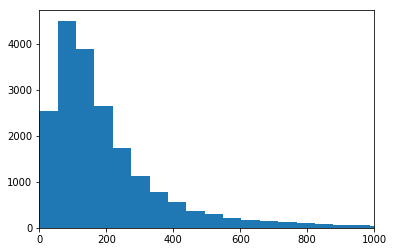

In [8]:
nn = np.array([len(seq) for seq in sequences])
print('Seq. length min/max/mean/median:', nn.min(), nn.max(), nn.mean(), np.median(nn))

print('Word indexes min/max:', data.min(), data.max(), end='\n\n')

plot.hist(nn, bins=500)
plot.xlim(0, 1000)

i2w = dict([(v, k) for k, v in word_index.items()])

for i in nr.randint(5000, size=5):
    seq = data[i]
    print('{:5d}: {}\n'.format(i, ' '.join([i2w[x] for x in seq[:50] if x > 0])))

In [9]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
targets = targets[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = targets[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = targets[-num_validation_samples:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


(15998, 1000) (15998, 20)
(3999, 1000) (3999, 20)


In [10]:
print('Preparing embedding matrix: ', end='')

# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# for word, i in word_index.items():
#     if i >= MAX_NB_WORDS:
#         continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

i2w = dict([(v, k) for k, v in word_index.items()])

for i in range(1, MAX_NB_WORDS):
    word = i2w[i]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)
embeddings_index = None

Preparing embedding matrix: (20000, 100)


In [11]:
aa = embedding_matrix.sum(1)
aa[aa==0].shape

(2100,)

## Criação do modelo

In [12]:
model_name = '../../models/word_embeddings_1'

def build_net(embedding_matrix=None, input_len=None, trainable=False):
    num_words, embedding_dim = embedding_matrix.shape
    
    seq_input = Input(shape=(input_len,), dtype='int32')
    embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix],
                                input_length=input_len, trainable=trainable)(seq_input)

    x = Conv1D(128, 5, activation='relu')(embedding_layer)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    x = Dropout(0.5)(x)
    
    preds = Dense(len(labels_index), activation='softmax')(x)

    model = Model(seq_input, preds)
    return model


## Treinamento

In [13]:
build_params = (embedding_matrix, MAX_SEQUENCE_LENGTH, False)
fit_params = {
    'opt':             'adam',     #SGD(lr=0.01, momentum=0.9, nesterov=True), 
    'batch_size':      64, 
    'nepochs':         100, 
    'patience':        10,
    'nr_seed':         20170601,
    'ploss':           0.0,
    'reset':           False,
}

train_network(model_name, build_net, build_params, x_train, y_train, x_val, y_val, **fit_params);


[INFO] loading model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 97, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 93, 128)        

## Avaliação

In [14]:
test_network(model_name, x_val, y_val)

Model from epoch 6
[INFO] evaluating in the test data set ...
3999/3999 [==============================] - 0s     

[INFO] accuracy on the test data set: 32.26% [3.01098]
